In [1]:
import pandas as pd
import numpy as np

# Prepare Heart data

In [2]:
df = pd.read_csv("dataset/heart.csv", sep=',')
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [4]:
from sklearn.model_selection import train_test_split

y_name = 'output'
y = df[y_name]
X = df.drop(y_name, axis=1)

For using basick pipeline we need to binarize data. For categorical fields it is quite easy, we will use Sklearn LabelBinarizer. But for numerical fields we need to cjoose stratage. We have five fields numerical fields Age, trtbps, chol, thalachh. For Age and trtbps we will use range stratage because there are quite popular classification in biology for them. For chol, thalach and oldpeak we will use at least stratage and set trasholds with 0.25, 0.50, 0.75 percentiles.

In [5]:
test_size = 0.1
numerical_names = {'age', 'trtbps', 'chol', 'thalachh', 'oldpeak'}

In [6]:
from utils import binarize_categorical, binarize_by_range, binarize_by_percentile

def prepare_data(X: pd.DataFrame):
    X_binarized = binarize_categorical(X, set(X.columns) - numerical_names)
    X_binarized = binarize_by_range(X_binarized, [21, 35, 60, 75], 'age')
    X_binarized = binarize_by_range(X_binarized, [100, 119, 129, 139, 159, 179], 'trtbps')
    X_binarized = binarize_by_percentile(X_binarized, ['chol', 'thalachh', 'oldpeak'])
    X_binarized = X_binarized.astype(bool)
    X_bin = [set(X_binarized.columns[x]) for idx, x in X_binarized.iterrows()]
    return X_bin

X_bin = prepare_data(X)
y = y.astype(bool)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y, random_state=42, test_size=test_size, shuffle=True, stratify=y)
X_str = X.copy(deep=True)
X_str[list(set(X.columns) - numerical_names)] = X_str[list(set(X.columns) - numerical_names)].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_str, y, random_state=42, test_size=test_size, shuffle=True, stratify=y)

In [7]:
X_train.shape, X_test.shape

((272, 13), (31, 13))

In [8]:
n_train = int(len(X)*(1 - test_size))
n_test = len(X) - n_train
n_train, n_test

(272, 31)

# Test Baseline algorithms

In [9]:
%%time
import lazy_pipeline as lpipe
gen = lpipe.predict_array(
    X_train_bin + X_test_bin,
    y_train_bin.to_list() + y_test_bin.to_list(),
    n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 303/303 [00:00<00:00, 152.80it/s]

CPU times: user 209 ms, sys: 13.7 ms, total: 222 ms
Wall time: 220 ms


In [10]:
%%time
gen = lpipe.predict_array(
    X_train_bin + X_test_bin,
    y_train_bin.to_list() + y_test_bin.to_list(),
    n_train, use_tqdm=True, update_train=False)
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 303/303 [00:00<00:00, 170.03it/s]

CPU times: user 183 ms, sys: 3.89 ms, total: 187 ms
Wall time: 185 ms


In [11]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
score_f = f1_score
score_name = score_f.__name__
preds = y_preds
score_vals[score_name] = [score_f(y_test_bin.iloc[:i], preds[:i], zero_division=True) for i in range(1, len(preds))]

score_name = score_f.__name__ + '_fixedtrain'
preds = y_preds_fixedtrain
score_vals[score_name] = [score_f(y_test_bin.iloc[:i], preds[:i], zero_division=True) for i in range(1, len(preds))]

score_f = accuracy_score
score_name = score_f.__name__
preds = y_preds
score_vals[score_name] = [score_f(y_test_bin.iloc[:i], preds[:i]) for i in range(1, len(preds))]

score_name = score_f.__name__ + '_fixedtrain'
preds = y_preds_fixedtrain
score_vals[score_name] = [score_f(y_test_bin.iloc[:i], preds[:i]) for i in range(1, len(preds))]

# Test new proposed algorithm

In [12]:
%%time
from lazy_fca_estimator import LazyFCA

fca = LazyFCA(
    consistency_threshold=0.95,
    undefined_treshhold=0.9,
    min_extent_size=7,
    check_number=1,
    update_train=True,
    numerical_preprocessing='min_inf_interval'
)

prediction_min, t_preds_min = lpipe.apply_stopwatch(fca.predict(X_test, X_train, y_train, generator=True, verbose=1))

Predicting data....: 100%|██████████| 31/31 [00:00<00:00, 73.83it/s]

CPU times: user 423 ms, sys: 4.94 ms, total: 428 ms
Wall time: 426 ms


In [13]:
%%time
from lazy_fca_estimator import LazyFCA

fca = LazyFCA(
    consistency_threshold=0.9,
    undefined_treshhold=0.95,
    min_extent_size=2,
    check_number=1,
    update_train=True
)

prediction_base, t_preds_base = lpipe.apply_stopwatch(fca.predict(X_test, X_train, y_train, generator=True, verbose=1))

Predicting data....: 100%|██████████| 31/31 [00:00<00:00, 628.26it/s]

CPU times: user 53.9 ms, sys: 1.91 ms, total: 55.8 ms
Wall time: 54.5 ms


In [14]:
from undefine_scores import f1_undefine_score, accuracy_undefine_score
preds = prediction_min
score_vals['accuracy_score_new_min_inf'] = [accuracy_undefine_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_new_min_inf'] = [f1_undefine_score(y_test.iloc[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]
preds = prediction_base
score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_new'] = [f1_undefine_score(y_test.iloc[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]

/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:59: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(y_test == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:92: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(predict == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:59: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(y_test == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:92: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(predict == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:92: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) &

# Popular estimators

In [15]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
normalizer.fit(X)
X_normalized = normalizer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, random_state=42, test_size=test_size, shuffle=True, stratify=y)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000)

parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit_cv = GridSearchCV(lr, parameters, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
logit_cv.fit(X_normalized, y)
logit_cv_estimator = logit_cv.best_estimator_
prediction_lr = logit_cv_estimator.predict(X_test)
print("Best params:", logit_cv.best_params_)
print("Best cross validaton score %.2f"%(logit_cv.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'C': 0.1}
Best cross validaton score 0.85


In [17]:
preds = prediction_lr
score_vals['accuracy_score_lr'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_lr'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

In [18]:
from sklearn.svm import SVC

svc = SVC(random_state=5, gamma='auto')

parameters = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svc_cv = GridSearchCV(svc, parameters, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
svc_cv.fit(X_normalized, y)
svc_best = svc_cv.best_estimator_
prediction_svc = svc_best.predict(X_test)
print("Best params:", svc_cv.best_params_)
print("Best cross validaton score %.2f"%(svc_cv.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'C': 0.1}
Best cross validaton score 0.85


In [19]:
preds = prediction_svc
score_vals['accuracy_score_svc'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_svc'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

In [20]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

rf_cv = GridSearchCV(rf, parameters, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
rf_cv.fit(X_normalized, y)
best_forest = rf_cv.best_estimator_
prediction_forest = best_forest.predict(X_test)
print("Best params:", rf_cv.best_params_)
print("Best cross validaton score %.2f"%(rf_cv.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 9}
Best cross validaton score 0.86


In [21]:
preds = prediction_forest
score_vals['accuracy_score_rf'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_rf'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

# Compare

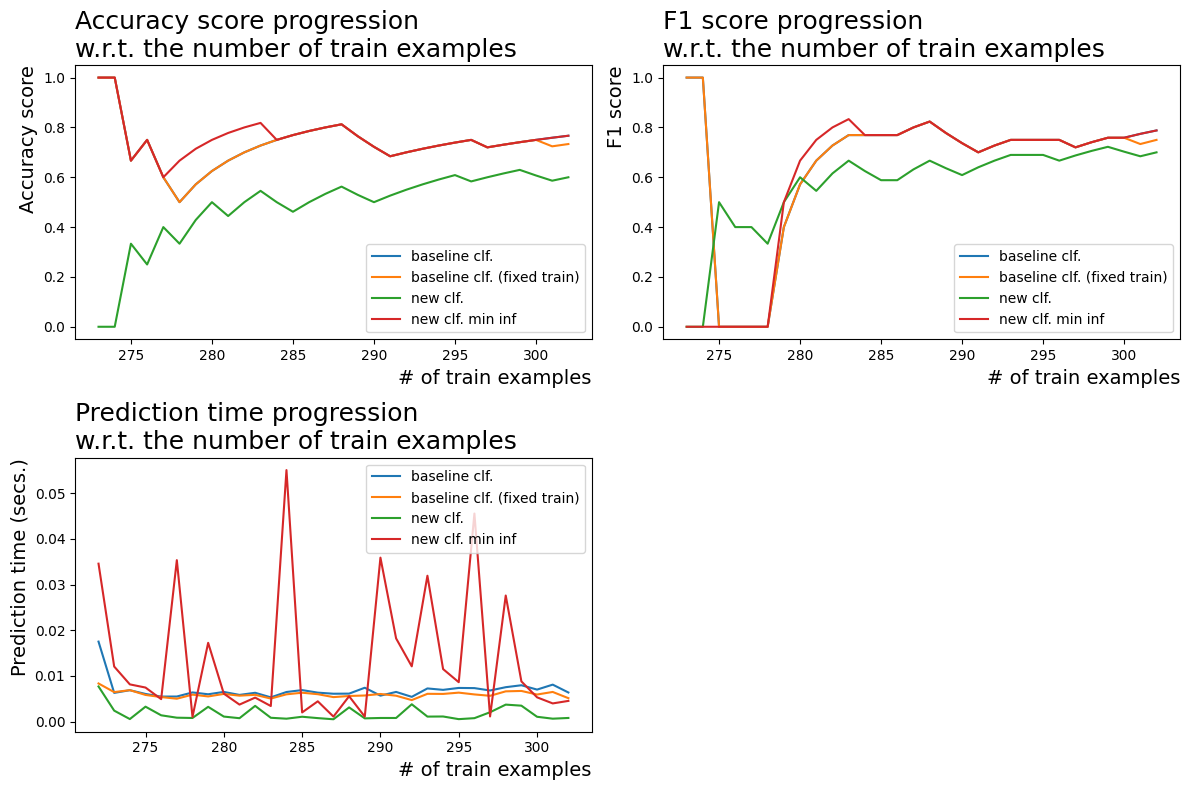

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new'], label='new clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new_min_inf'], label='new clf. min inf')
    
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')
axs[1,0].plot(range(n_train, len(X)), t_preds_base, label='new clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_min, label='new clf. min inf')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('image/Classifier_comparison_heart.png')
plt.show()

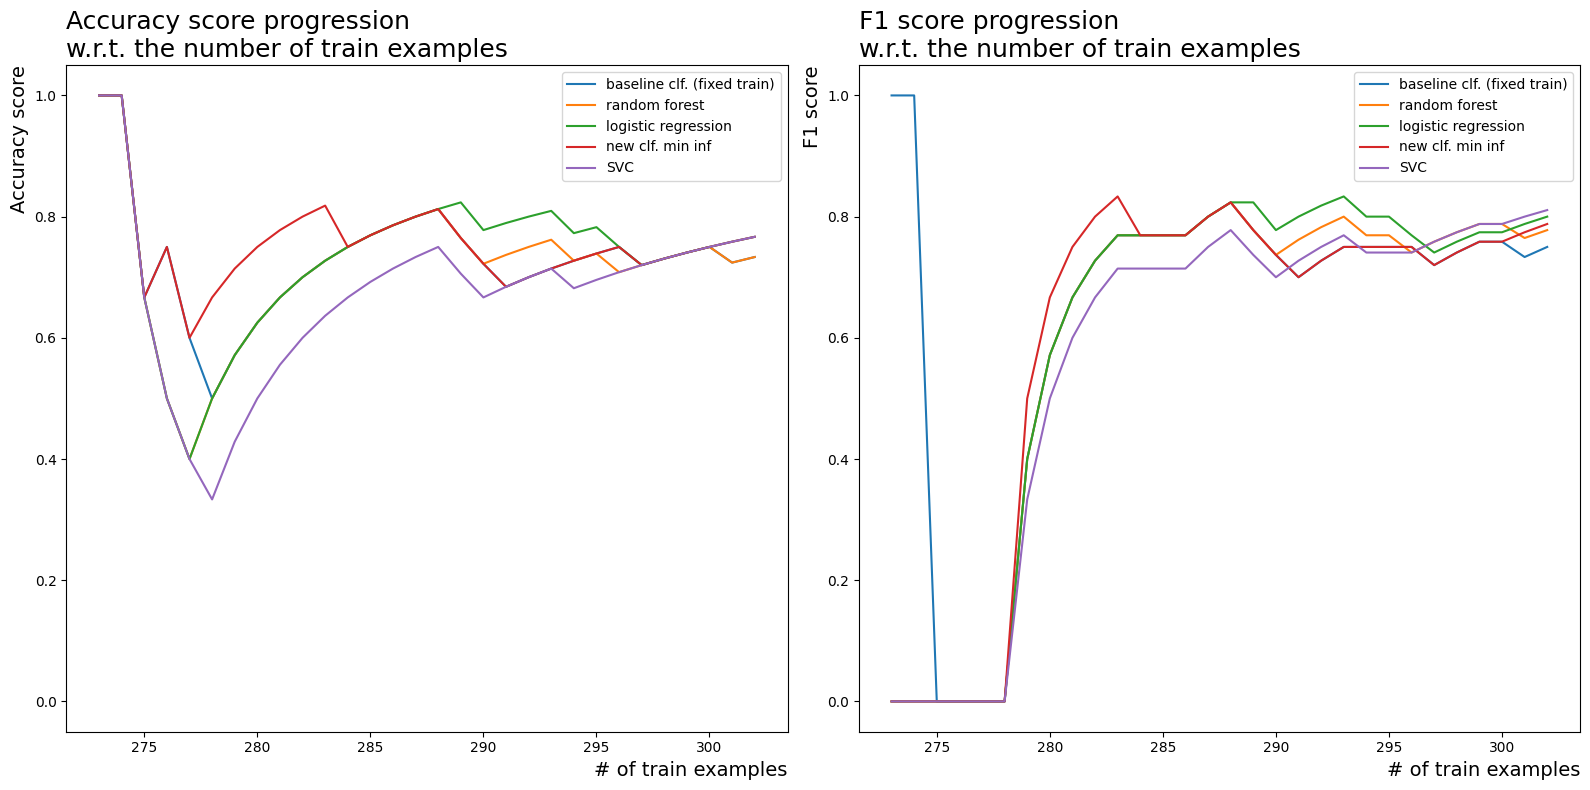

In [23]:

plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs,['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_rf'], label='random forest')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_lr'], label='logistic regression')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new_min_inf'], label='new clf. min inf')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_svc'], label='SVC')
    

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score'], ['','']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    


# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('image/Classifier_comparison_heart_sklearn.png')
plt.show()